In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
aapl = pd.read_csv("Data/AAPL.csv")
spy = pd.read_csv("Data/SPY.csv")

d = pd.merge(aapl, spy, how='outer', on='Date')
d.head()

,Date,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y
0,1981-01-02,0.154018,0.155134,0.154018,0.154018,0.120388,21660800,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-05,0.151228,0.151228,0.150670,0.150670,0.117771,35728000,NaN,NaN,NaN,NaN,NaN,NaN
2,1981-01-06,0.144531,0.144531,0.143973,0.143973,0.112536,45158400,NaN,NaN,NaN,NaN,NaN,NaN
3,1981-01-07,0.138393,0.138393,0.137835,0.137835,0.107739,55686400,NaN,NaN,NaN,NaN,NaN,NaN
4,1981-01-08,0.135603,0.135603,0.135045,0.135045,0.105558,39827200,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
d = d[["Adj Close_x", "Adj Close_y"]]
d = d.rename(columns={"Adj Close_x":"AAPL", "Adj Close_y":"SPY"})

In [4]:
d

,AAPL,SPY
0,0.120388,NaN
1,0.117771,NaN
2,0.112536,NaN
3,0.107739,NaN
4,0.105558,NaN
...,...,...
10400,174.610001,451.640015
10401,174.309998,452.920013
10402,178.440002,456.799988
10403,175.059998,451.029999


In [5]:
# find the sign of each moving average cross over
# add 1 and divide by 2 to get long only signals
d['Signals'] = (np.sign(d['AAPL'].rolling(20).mean() - d['AAPL'].rolling(200).mean())+1)/2

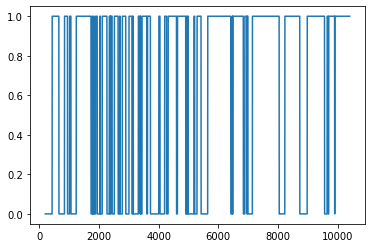

<Figure size 1080x720 with 0 Axes>

In [6]:
plt.plot(d['Signals'])
plt.figure(figsize=(15, 10))
plt.show()

In [7]:
# get returns of the strategy
# multiply the pct chage by every time the long signal (cross over) = 1
# shift returns inorder to get correct returns for previous day
d['rets'] = d['AAPL'].pct_change()
d['Strat rets'] = d['rets'].shift(-1)*d['Signals']

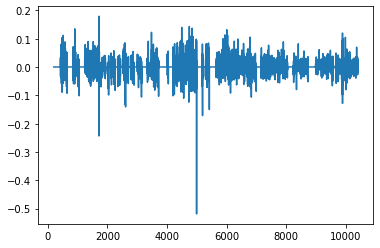

<Figure size 1080x720 with 0 Axes>

In [8]:
plt.plot(d['Strat rets'])
plt.figure(figsize=(15, 10))
plt.show()

In [9]:
# implies same trade size
d['Strat Rets Cumulative'] = d['Strat rets'].cumsum()
# implies reinvesting all profits
d['Strat Rets Compound'] = (1+d['Strat rets']).cumprod()

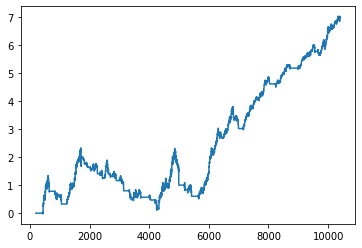

<Figure size 1080x720 with 0 Axes>

In [10]:
plt.plot(d['Strat Rets Cumulative'])
plt.figure(figsize=(15, 10))
plt.show()

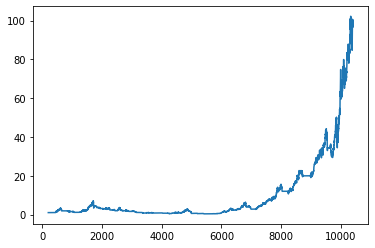

<Figure size 1080x720 with 0 Axes>

In [11]:
plt.plot(d['Strat Rets Compound'])
plt.figure(figsize=(15, 10))
plt.show()

In [12]:
# reset is 1 for trade entry and -1 for trade exit
d['Reset Trade'] = np.sign(d['Signals'].diff())

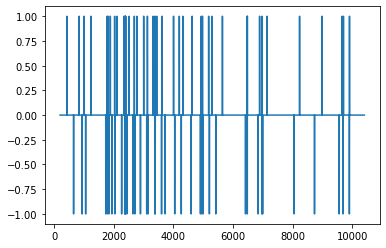

<Figure size 1080x720 with 0 Axes>

In [13]:
plt.plot(d['Reset Trade'])
plt.figure(figsize=(15, 10))
plt.show()

In [14]:
# find cumulative entry price for p/l curve.
# foward fill this value until we ex
d["Trade Entry"] = (d['Strat Rets Cumulative']*d['Reset Trade'].where(d['Reset Trade']==1)).ffill()

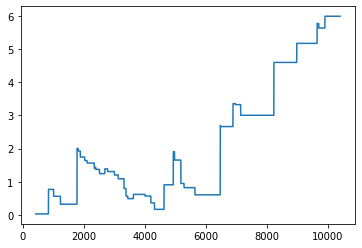

<Figure size 1080x720 with 0 Axes>

In [15]:
plt.plot(d['Trade Entry'])
plt.figure(figsize=(15, 10))
plt.show()

In [16]:
# by removing the entry prices of each trade from cumulative p/l we can see the p/l of each trade
# multiply by cross over (i.e. in trade or not)
d['Trade PL'] = (d['Strat Rets Cumulative'] - d['Trade Entry'])*d['Signals']

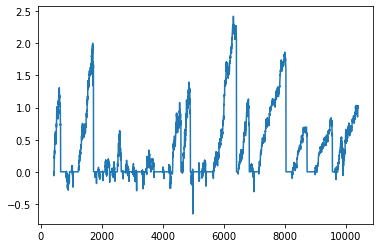

<Figure size 1080x720 with 0 Axes>

In [17]:
plt.plot(d['Trade PL'])
plt.figure(figsize=(15, 10))
plt.show()

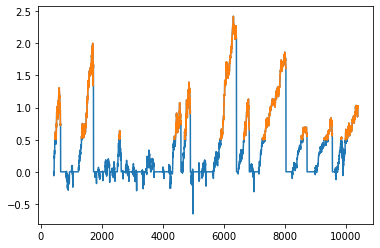

<Figure size 1080x720 with 0 Axes>

In [18]:
# We can set take proft at 0.5
# everything in orange shows the trade if we DONT take profit
plt.plot(d['Trade PL'])
plt.plot(d['Trade PL'].where(d['Trade PL']>0.5))
plt.figure(figsize=(15, 10))
plt.show()

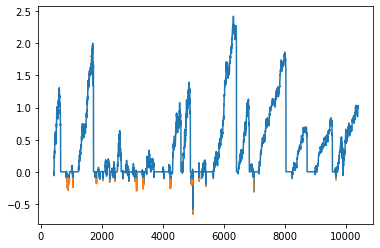

<Figure size 1080x720 with 0 Axes>

In [19]:
# We can set take proft at -0.1
# everything in orange shows the trade if we DONT stop loss
plt.plot(d['Trade PL'])
plt.plot(d['Trade PL'].where(d['Trade PL']<-0.1))
plt.figure(figsize=(15, 10))
plt.show()

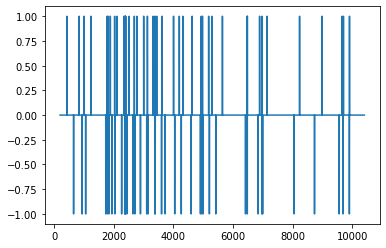

<Figure size 1080x720 with 0 Axes>

In [20]:
# these are our natural signals
# each up tick is an entry and down is an exit
# we need to take all the points from above and overlay them as additional exit signals
plt.plot(d['Signals'].diff())
plt.figure(figsize=(15, 10))
plt.show()

In [21]:
# To get these take profit / stop signals, we can take the Trade PL series and cut it off at a given point 
# copy the Trade PL series to form the basis of these chopped signals
d['Chopped PL'] = d['Trade PL'].copy()

In [22]:
# First we get get every point above our signal and fill and find the sign 
# the sign turns anything above to 1
# this turns the gaps to NaN so we fill with zeros
# then, before .diff(), every up edge to 1 indicates a trade is above the profit take, but downward can indicate either a natural close or a proit take
# Threfore use diff, after which, each upward edge indicated a closed trade
# then we must replace zeroes with nans to foward fill our exit untill the next entry
# then again we normalise the signals 
# finally we replace nans again with 0 and make signals negative as they are exits
d['Chopped PL'] = (-(np.sign(d['Chopped PL'].where(d['Chopped PL']>0.5)).fillna(0).diff().replace(0, np.nan)+1)/2).fillna(0)

[]

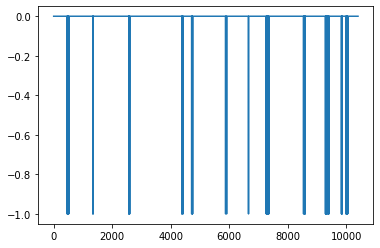

In [23]:
plt.plot(d['Chopped PL'])
plt.plot()

In [24]:
# Now we need to combine the regular entry and exit signals with the take profit exit signals above
# we should expect more exit signals than entry signals (i.e. take profit followed by natural trade close from MA cross)
# replaceing zeroes with NaN we can foward fill our first exit after entry to the next entry
# normalize again so we can multiply by P/L
d['Strat Signals + Take Profit'] = ((d['Signals'].diff() + d['Chopped PL']).replace(0, np.nan).ffill()+1)/2

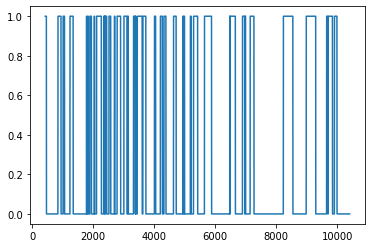

In [25]:
plt.plot(d['Strat Signals + Take Profit'])
plt.show()

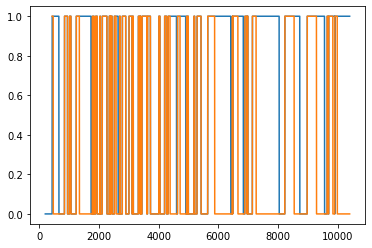

In [26]:
# Overlaying these new signals with our original (in blue) we can see where we would have exited vs if not
plt.plot(d['Signals'])
plt.plot(d['Strat Signals + Take Profit'])
plt.show()

In [27]:
# Compare these trades interms of cumulative returns
d["Trade PL With Stop"] = (d['rets'].shift(-1)*d['Strat Signals + Take Profit']).cumsum()

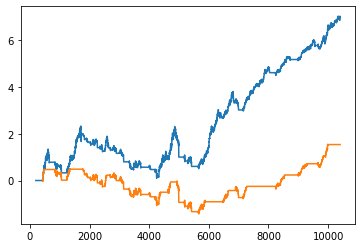

In [28]:
# Blue shows WITHOUT TAKE PROFIT
# Oragne shows WITH TAKE PROFIT
plt.plot(d['Strat Rets Cumulative'])
plt.plot(d['Trade PL With Stop'])
plt.show()